# Import Necessary Libraries

In [183]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np
import tensorflow as tf
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, \
mean_absolute_error, explained_variance_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, \
GlobalAveragePooling1D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Exploratory Data Analysis (EDA)

## Calendar Data - 2022

In [184]:
#Load raw calendar data from file
raw_calendar_data = pd.read_csv('../Data/AirBnB/Nashville/2021/nashville_calendar_2021.csv', compression='gzip')
raw_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,6422,2021-12-17,f,$40.00,$40.00,30,365
1,3095791,2021-12-17,t,$80.00,$80.00,30,1125
2,3095791,2021-12-18,t,$80.00,$80.00,30,1125
3,3095791,2021-12-19,t,$60.00,$60.00,30,1125
4,3095791,2021-12-20,t,$60.00,$60.00,30,1125
...,...,...,...,...,...,...,...
2320685,53784244,2022-12-12,t,$275.00,$248.00,2,1125
2320686,53784244,2022-12-13,t,$275.00,$248.00,2,1125
2320687,53784244,2022-12-14,f,$275.00,$248.00,2,1125
2320688,53784244,2022-12-15,f,$275.00,$248.00,2,1125


In [185]:
#Check the info / types of data
raw_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           object
 4   adjusted_price  object
 5   minimum_nights  int64 
 6   maximum_nights  int64 
dtypes: int64(3), object(4)
memory usage: 123.9+ MB


In [186]:
#Convert date column to date-times type
mod_calendar_data = raw_calendar_data
mod_calendar_data['date'] = pd.to_datetime(raw_calendar_data['date'])

#Confirm the info / types of data
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  int64         
 6   maximum_nights  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 123.9+ MB


In [187]:
print(f"Earliest date of data set {raw_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_calendar_data['date'].max()}")

Earliest date of data set 2021-12-17 00:00:00
Latest date of data set 2022-12-16 00:00:00


In [188]:
#Check Values of 'Available column'
mod_calendar_data['available'].value_counts()

t    1287027
f    1033663
Name: available, dtype: int64

In [189]:
#Replace the false and true values with 0 and 1
mod_calendar_data['available'] = mod_calendar_data['available'].replace(['f', 't'],[0, 1])

#Confirm available are now integers
mod_calendar_data['available'].value_counts()

1    1287027
0    1033663
Name: available, dtype: int64

In [190]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int64         
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  int64         
 6   maximum_nights  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 123.9+ MB


In [191]:
mod_calendar_data['price'].value_counts()

$150.00      40292
$200.00      38362
$199.00      34912
$99.00       34348
$250.00      33883
             ...  
$4,516.00        1
$4,558.00        1
$4,824.00        1
$7,901.00        1
$5,500.00        1
Name: price, Length: 4161, dtype: int64

In [192]:
mod_calendar_data['price'].isna().sum()

0

In [193]:
mod_calendar_data['adjusted_price'].value_counts()

$150.00      39901
$200.00      37574
$250.00      33182
$199.00      31654
$99.00       30456
             ...  
$8,448.00        1
$4,933.00        1
$4,657.00        1
$4,700.00        1
$5,500.00        1
Name: adjusted_price, Length: 4165, dtype: int64

In [194]:
nan_cols = mod_calendar_data[mod_calendar_data['price'].isna()]
nan_cols['listing_id'].value_counts()

Series([], Name: listing_id, dtype: int64)

In [195]:
bnb_to_drop = mod_calendar_data[(mod_calendar_data['listing_id'] == 47732580)].index
mod_calendar_data = mod_calendar_data.drop(bnb_to_drop)
mod_calendar_data['price'].isna().sum()

0

In [196]:
mod_calendar_data['price']

0             $40.00
1             $80.00
2             $80.00
3             $60.00
4             $60.00
             ...    
2320685      $275.00
2320686      $275.00
2320687      $275.00
2320688      $275.00
2320689    $1,075.00
Name: price, Length: 2320690, dtype: object

In [197]:
test_price_df = mod_calendar_data['price'].str.split(".", expand=True)
test_price_df = test_price_df.rename(columns = {0 : 'daily_price'})
test_price_df = test_price_df.drop(labels = [1], axis = 1)
mod_calendar_data = test_price_df.join(mod_calendar_data, how = 'left')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace(',', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].astype({'daily_price':'int'})
mod_calendar_data = mod_calendar_data.drop(labels = ['adjusted_price', 'price'], axis = 1)

id_to_move = mod_calendar_data.pop('listing_id')
mod_calendar_data.insert(0, 'listing_id', id_to_move)
mod_calendar_data

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_5153/3964135494.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')


,listing_id,daily_price,date,available,minimum_nights,maximum_nights
0,6422,40,2021-12-17,0,30,365
1,3095791,80,2021-12-17,1,30,1125
2,3095791,80,2021-12-18,1,30,1125
3,3095791,60,2021-12-19,1,30,1125
4,3095791,60,2021-12-20,1,30,1125
...,...,...,...,...,...,...
2320685,53784244,275,2022-12-12,1,2,1125
2320686,53784244,275,2022-12-13,1,2,1125
2320687,53784244,275,2022-12-14,0,2,1125
2320688,53784244,275,2022-12-15,0,2,1125


In [198]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   daily_price     int64         
 2   date            datetime64[ns]
 3   available       int64         
 4   minimum_nights  int64         
 5   maximum_nights  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 106.2 MB


In [199]:
#For purposes of this project/the stakeholder, we will drop the adjusted avail, price, min nights, max nights
mod_calendar_data = mod_calendar_data.drop(['available', 'minimum_nights', 'maximum_nights'],
                                          axis = 1)

In [200]:
#Check all columns are integer types
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   listing_id   int64         
 1   daily_price  int64         
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 53.1 MB


In [201]:
# mod_calendar_data_id_avail = mod_calendar_data.groupby(['listing_id']).sum()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.reset_index()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['price'], axis = 1)
# mod_calendar_data_id_avail['perc_year_avail'] = mod_calendar_data_id_avail['available'] / 365
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['available'], axis = 1)
# mod_calendar_data_id_avail

In [202]:
# mod_calendar_data_id_avail.info()

## Listings Data - 2022

In [203]:
raw_listings_data = pd.read_csv('../Data/AirBnB/Nashville/2021/nashville_listings_2021.csv')
raw_listings_data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6422,https://www.airbnb.com/rooms/6422,20211217003604,2021-12-17,Nashville Charm,30 day or more rental during COVID. Show COVID...,Historic East Nashville is home to many new an...,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,...,4.96,4.92,4.98,NaN,f,1,0,1,0,4.38
1,39870,https://www.airbnb.com/rooms/39870,20211217003604,2021-12-17,Close to Vanderbilt 2,This is a room and private bathroom in my cozy...,"The house is in a safe, quiet, ""college"" neig...",https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,...,4.98,4.94,4.94,NaN,f,1,0,1,0,4.17
2,72906,https://www.airbnb.com/rooms/72906,20211217003604,2021-12-17,Vandy/Belmont/10 mins to Broadway - Sunny 800 ...,Entire top floor. Private. 800 sq ft of bright...,Historic Belmont-Hillsboro neighborhood. Walk-...,https://a0.muscache.com/pictures/58602855/3788...,176117,https://www.airbnb.com/users/show/176117,...,4.99,4.96,4.88,NaN,f,1,1,0,0,4.74
3,258817,https://www.airbnb.com/rooms/258817,20211217003604,2021-12-17,ButterflyRoom-private bath- open in oct,Morningstar House! Extended stay - 3+ months- ...,"I'm very near the Percy Priest Lake, natural ...",https://a0.muscache.com/pictures/eef19bc4-2743...,22296,https://www.airbnb.com/users/show/22296,...,4.90,4.74,4.73,NaN,f,7,0,6,1,0.79
4,289242,https://www.airbnb.com/rooms/289242,20211217003604,2021-12-17,"MorningstarHouse, monthly room- open sept",Morningstar House! Extended stay - price reduc...,The Morningstar House is in a quiet cul-de-sac...,https://a0.muscache.com/pictures/40a7ab72-20f7...,22296,https://www.airbnb.com/users/show/22296,...,4.78,4.47,4.69,NaN,f,7,0,6,1,0.63


In [204]:
raw_listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6360 entries, 0 to 6359
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6360 non-null   int64  
 1   listing_url                                   6360 non-null   object 
 2   scrape_id                                     6360 non-null   int64  
 3   last_scraped                                  6360 non-null   object 
 4   name                                          6359 non-null   object 
 5   description                                   6312 non-null   object 
 6   neighborhood_overview                         4606 non-null   object 
 7   picture_url                                   6360 non-null   object 
 8   host_id                                       6360 non-null   int64  
 9   host_url                                      6360 non-null   o

In [205]:
#Remove irrelevant review columns
mod_listing_data = raw_listings_data.drop(labels = ['review_scores_accuracy', 
                                                    'review_scores_cleanliness', 
                                                    'review_scores_checkin', 
                                                    'review_scores_communication', 
                                                    'review_scores_location',
                                                    'calendar_updated', 
                                                    'license'], axis = 1)

In [206]:
#Remove irrelevant host columns
mod_listing_data = mod_listing_data.drop(labels = ['host_name', 
                                                   'host_since', 
                                                   'host_location', 
                                                   'host_about', 
                                                   'host_response_time', 
                                                   'host_acceptance_rate',
                                                   'host_thumbnail_url', 
                                                   'host_picture_url', 
                                                   'host_neighbourhood', 
                                                   'host_listings_count', 
                                                   'host_total_listings_count', 
                                                   'host_verifications', 
                                                   'host_has_profile_pic',
                                                   'first_review',
                                                   'last_review'], axis = 1)

In [207]:
#Remove

mod_listing_data = mod_listing_data.drop(labels = ['scrape_id',
                                                  'last_scraped',
                                                  'neighbourhood_cleansed',
                                                  'neighbourhood_group_cleansed',
                                                  'property_type',
                                                  'bathrooms',
                                                  'price',
                                                   'minimum_minimum_nights',
                                                   'maximum_minimum_nights',
                                                   'minimum_maximum_nights',
                                                   'maximum_maximum_nights',
                                                   'minimum_nights_avg_ntm',
                                                   'maximum_nights_avg_ntm',
                                                   'has_availability',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'calendar_last_scraped',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calculated_host_listings_count_private_rooms',
                                                   'calculated_host_listings_count_shared_rooms',
                                                  'neighborhood_overview',
                                                  'reviews_per_month',
                                                  'review_scores_value',
                                                  'host_response_rate',
                                                  'description'], axis = 1)

In [208]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6360 entries, 0 to 6359
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6360 non-null   int64  
 1   listing_url             6360 non-null   object 
 2   name                    6359 non-null   object 
 3   picture_url             6360 non-null   object 
 4   host_id                 6360 non-null   int64  
 5   host_url                6360 non-null   object 
 6   host_is_superhost       6186 non-null   object 
 7   host_identity_verified  6186 non-null   object 
 8   neighbourhood           4606 non-null   object 
 9   latitude                6360 non-null   float64
 10  longitude               6360 non-null   float64
 11  room_type               6360 non-null   object 
 12  accommodates            6360 non-null   int64  
 13  bathrooms_text          6355 non-null   object 
 14  bedrooms                6035 non-null   

In [209]:
#Fill the missing neighborhood data with 'Nashville, Tennessee, United States'
mod_listing_data['neighbourhood'] = mod_listing_data['neighbourhood'].fillna('Nashville, Tennessee, United States')
mod_listing_data['neighbourhood'].isna().sum()

0

In [210]:
test_neighbor_df = mod_listing_data['neighbourhood'].str.split(",", expand=True)
test_neighbor_df = test_neighbor_df.rename(columns = {0 : 'neighborhood'})
test_neighbor_df = test_neighbor_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_neighbor_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['neighbourhood'], axis = 1)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6360 entries, 0 to 6359
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6360 non-null   int64  
 1   listing_url             6360 non-null   object 
 2   name                    6359 non-null   object 
 3   picture_url             6360 non-null   object 
 4   host_id                 6360 non-null   int64  
 5   host_url                6360 non-null   object 
 6   host_is_superhost       6186 non-null   object 
 7   host_identity_verified  6186 non-null   object 
 8   latitude                6360 non-null   float64
 9   longitude               6360 non-null   float64
 10  room_type               6360 non-null   object 
 11  accommodates            6360 non-null   int64  
 12  bathrooms_text          6355 non-null   object 
 13  bedrooms                6035 non-null   float64
 14  beds                    6312 non-null   

In [211]:
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Nashville '],['Nashville'])

neigh_to_drop = mod_listing_data[(mod_listing_data['neighborhood'] != 'Nashville')].index
mod_listing_data = mod_listing_data.drop(neigh_to_drop)

In [212]:
mod_listing_data['neighborhood'].value_counts()

Nashville    6311
Name: neighborhood, dtype: int64

In [220]:
#Remove rows with no bedrooms data
mod_listing_data = mod_listing_data.dropna(subset = ['bedrooms', 
                                                     'beds', 
                                                     'review_scores_rating', 
                                                     'bathrooms_text',
                                                     'host_is_superhost',
                                                     'host_identity_verified'], axis = 0)

In [221]:
mod_listing_data.isna().sum()

id                        0
listing_url               0
name                      0
picture_url               0
host_id                   0
host_url                  0
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
neighborhood              0
dtype: int64

In [222]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_is_superhost'] = mod_listing_data['host_is_superhost'].replace(['f', 't'],[0, 1])
mod_listing_data['host_is_superhost'].value_counts()

1.0    3064
0.0    2139
Name: host_is_superhost, dtype: int64

In [223]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_identity_verified'] = mod_listing_data['host_identity_verified'].replace(['f', 't'],[0, 1])
mod_listing_data['host_identity_verified'].value_counts()

1.0    4466
0.0     737
Name: host_identity_verified, dtype: int64

In [224]:
#Replace the false and true values with 0 and 1
mod_listing_data['instant_bookable'] = mod_listing_data['instant_bookable'].replace(['f', 't'],[0, 1])
mod_listing_data['instant_bookable'].value_counts()

1    2957
0    2246
Name: instant_bookable, dtype: int64

In [225]:
mod_listing_data['neighborhood'].value_counts()

Nashville    5203
Name: neighborhood, dtype: int64

In [226]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1897
2 baths              856
2.5 baths            450
3.5 baths            445
3 baths              356
1 private bath       321
4 baths              310
1.5 baths            175
1 shared bath        126
4.5 baths             61
8 baths               34
1.5 shared baths      29
7 baths               25
6 baths               23
2 shared baths        22
5 baths               22
5.5 baths             11
4 shared baths        10
9 baths                6
6.5 baths              4
0 baths                4
7 shared baths         4
14 baths               2
8.5 baths              2
Half-bath              1
7.5 baths              1
3 shared baths         1
2.5 shared baths       1
17 baths               1
3.5 shared baths       1
10 baths               1
16 baths               1
Name: bathrooms_text, dtype: int64

In [227]:
mod_listing_data['instant_bookable'].value_counts()

1    2957
0    2246
Name: instant_bookable, dtype: int64

In [228]:
mod_listing_data['beds'].value_counts()

2.0     1134
1.0     1024
3.0      829
4.0      627
5.0      420
6.0      321
7.0      197
8.0      195
9.0       90
10.0      79
12.0      66
11.0      56
13.0      34
14.0      31
16.0      28
15.0      20
20.0      11
22.0       9
26.0       7
24.0       5
21.0       4
18.0       4
19.0       3
30.0       2
17.0       2
28.0       2
33.0       1
32.0       1
29.0       1
Name: beds, dtype: int64

In [229]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203 entries, 0 to 6322
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5203 non-null   int64  
 1   listing_url             5203 non-null   object 
 2   name                    5203 non-null   object 
 3   picture_url             5203 non-null   object 
 4   host_id                 5203 non-null   int64  
 5   host_url                5203 non-null   object 
 6   host_is_superhost       5203 non-null   float64
 7   host_identity_verified  5203 non-null   float64
 8   latitude                5203 non-null   float64
 9   longitude               5203 non-null   float64
 10  room_type               5203 non-null   object 
 11  accommodates            5203 non-null   int64  
 12  bathrooms_text          5203 non-null   object 
 13  bedrooms                5203 non-null   float64
 14  beds                    5203 non-null   

In [230]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [231]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1897
2 baths              856
2.5 baths            450
3.5 baths            445
3 baths              356
1 private bath       321
4 baths              310
1.5 baths            175
1 shared bath        126
4.5 baths             61
8 baths               34
1.5 shared baths      29
7 baths               25
6 baths               23
2 shared baths        22
5 baths               22
5.5 baths             11
4 shared baths        10
9 baths                6
6.5 baths              4
0 baths                4
7 shared baths         4
14 baths               2
8.5 baths              2
Half-bath              1
7.5 baths              1
3 shared baths         1
2.5 shared baths       1
17 baths               1
3.5 shared baths       1
10 baths               1
16 baths               1
Name: bathrooms_text, dtype: int64

In [232]:
mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 
                                                                                'Private half-bath'],
                                                                                 [0.5, 0.5, 0.5])

In [233]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [234]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1897
2 baths              856
2.5 baths            450
3.5 baths            445
3 baths              356
1 private bath       321
4 baths              310
1.5 baths            175
1 shared bath        126
4.5 baths             61
8 baths               34
1.5 shared baths      29
7 baths               25
6 baths               23
2 shared baths        22
5 baths               22
5.5 baths             11
4 shared baths        10
9 baths                6
6.5 baths              4
0 baths                4
7 shared baths         4
14 baths               2
8.5 baths              2
0.5                    1
7.5 baths              1
3 shared baths         1
2.5 shared baths       1
17 baths               1
3.5 shared baths       1
10 baths               1
16 baths               1
Name: bathrooms_text, dtype: int64

In [235]:
# mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].str.split(" ", n = 1, expand = True)

test_df = mod_listing_data['bathrooms_text'].str.split(" ", expand=True)
test_df = test_df.rename(columns = {0 : 'bathrooms'})
test_df = test_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['bathrooms_text'], axis = 1)
mod_listing_data['bathrooms'] = mod_listing_data['bathrooms'].fillna(0.5)
mod_listing_data['bathrooms'] = pd.to_numeric(mod_listing_data['bathrooms'])
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203 entries, 0 to 6322
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5203 non-null   int64  
 1   listing_url             5203 non-null   object 
 2   name                    5203 non-null   object 
 3   picture_url             5203 non-null   object 
 4   host_id                 5203 non-null   int64  
 5   host_url                5203 non-null   object 
 6   host_is_superhost       5203 non-null   float64
 7   host_identity_verified  5203 non-null   float64
 8   latitude                5203 non-null   float64
 9   longitude               5203 non-null   float64
 10  room_type               5203 non-null   object 
 11  accommodates            5203 non-null   int64  
 12  bedrooms                5203 non-null   float64
 13  beds                    5203 non-null   float64
 14  amenities               5203 non-null   

In [236]:
target_amenities = ['Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']

In [237]:
def add_amenity_column(amenity_name):
    mod_listing_data[amenity_name] = mod_listing_data['amenities'].str.contains(amenity_name, regex=False)
    mod_listing_data[amenity_name] = mod_listing_data[amenity_name].replace([False, True],[0, 1])

In [238]:
add_amenity_column(target_amenities[0])
add_amenity_column(target_amenities[1])
add_amenity_column(target_amenities[2])
add_amenity_column(target_amenities[3])
add_amenity_column(target_amenities[4])
add_amenity_column(target_amenities[5])
add_amenity_column(target_amenities[6])

In [239]:
mod_listing_data = mod_listing_data.drop(['amenities'], axis = 1)

In [240]:
mod_listing_data['listing_id'] = mod_listing_data['id']
mod_listing_data = mod_listing_data.drop(['id'], axis = 1)
column_to_move = mod_listing_data.pop('listing_id')
mod_listing_data.insert(0, 'listing_id', column_to_move)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203 entries, 0 to 6322
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              5203 non-null   int64  
 1   listing_url             5203 non-null   object 
 2   name                    5203 non-null   object 
 3   picture_url             5203 non-null   object 
 4   host_id                 5203 non-null   int64  
 5   host_url                5203 non-null   object 
 6   host_is_superhost       5203 non-null   float64
 7   host_identity_verified  5203 non-null   float64
 8   latitude                5203 non-null   float64
 9   longitude               5203 non-null   float64
 10  room_type               5203 non-null   object 
 11  accommodates            5203 non-null   int64  
 12  bedrooms                5203 non-null   float64
 13  beds                    5203 non-null   float64
 14  minimum_nights          5203 non-null   

## Combine Calendar Data and Listings Data

In [241]:
mod_calendar_data

,listing_id,daily_price,date
0,6422,40,2021-12-17
1,3095791,80,2021-12-17
2,3095791,80,2021-12-18
3,3095791,60,2021-12-19
4,3095791,60,2021-12-20
...,...,...,...
2320685,53784244,275,2022-12-12
2320686,53784244,275,2022-12-13
2320687,53784244,275,2022-12-14
2320688,53784244,275,2022-12-15


In [242]:
mod_calendar_data['listing_id']

0              6422
1           3095791
2           3095791
3           3095791
4           3095791
             ...   
2320685    53784244
2320686    53784244
2320687    53784244
2320688    53784244
2320689    53784244
Name: listing_id, Length: 2320690, dtype: int64

In [243]:
print(mod_listing_data.columns)
mod_calendar_data.columns

Index(['listing_id', 'listing_url', 'name', 'picture_url', 'host_id',
       'host_url', 'host_is_superhost', 'host_identity_verified', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'neighborhood', 'bathrooms',
       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer',
       'Heating'],
      dtype='object')


Index(['listing_id', 'daily_price', 'date'], dtype='object')

In [244]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   listing_id   int64         
 1   daily_price  int64         
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 53.1 MB


In [245]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203 entries, 0 to 6322
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              5203 non-null   int64  
 1   listing_url             5203 non-null   object 
 2   name                    5203 non-null   object 
 3   picture_url             5203 non-null   object 
 4   host_id                 5203 non-null   int64  
 5   host_url                5203 non-null   object 
 6   host_is_superhost       5203 non-null   float64
 7   host_identity_verified  5203 non-null   float64
 8   latitude                5203 non-null   float64
 9   longitude               5203 non-null   float64
 10  room_type               5203 non-null   object 
 11  accommodates            5203 non-null   int64  
 12  bedrooms                5203 non-null   float64
 13  beds                    5203 non-null   float64
 14  minimum_nights          5203 non-null   

### Drop Outliers

In [246]:
nashville_data = pd.merge(mod_listing_data, mod_calendar_data, how = 'left', on = 'listing_id')
nashville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899095 entries, 0 to 1899094
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       float64       
 7   host_identity_verified  float64       
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

In [247]:
nashville_data = nashville_data.dropna()

In [248]:
nashville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899095 entries, 0 to 1899094
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       float64       
 7   host_identity_verified  float64       
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

In [249]:
nashville_data['date'].value_counts()

2021-12-17    5203
2022-08-25    5203
2022-08-23    5203
2022-08-22    5203
2022-08-21    5203
              ... 
2022-04-16    5203
2022-04-15    5203
2022-04-14    5203
2022-04-13    5203
2022-12-16    5203
Name: date, Length: 365, dtype: int64

In [250]:
nashville_data['date'] = nashville_data['date'].replace(['2022-12-15'],['2021-12-15'])
nashville_data['date'] = nashville_data['date'].replace(['2022-12-16'],['2021-12-16'])
nashville_data['date'] = nashville_data['date'].replace(['2022-12-17'],['2021-12-17'])

In [251]:
nashville_data = nashville_data[nashville_data['bathrooms'] <= 6]
nashville_data = nashville_data[nashville_data['bathrooms'] >= 1]

nashville_data = nashville_data[nashville_data['bedrooms'] <= 6]
nashville_data = nashville_data[nashville_data['beds'] <= 11]
nashville_data = nashville_data[nashville_data['bathrooms'] <= 5]

nashville_data = nashville_data[nashville_data['room_type'] != 'Hotel room']
nashville_data = nashville_data[nashville_data['room_type'] != 'Shared room']

nashville_data = nashville_data[nashville_data['daily_price'] <= 1000]

In [252]:
nashville_data = nashville_data.reset_index()
nashville_data = nashville_data.drop(['index'], axis = 1)

In [253]:
nashville_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729496 entries, 0 to 1729495
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       float64       
 7   host_identity_verified  float64       
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

In [254]:
graphing_one_bnb = nashville_data[366:650]
graphing_one_bnb

,listing_id,listing_url,name,picture_url,host_id,host_url,host_is_superhost,host_identity_verified,latitude,longitude,...,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,date
366,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2021-12-18
367,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2021-12-19
368,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2021-12-20
369,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2021-12-21
370,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2021-12-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2022-09-23
646,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2022-09-24
647,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2022-09-25
648,39870,https://www.airbnb.com/rooms/39870,Close to Vanderbilt 2,https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,1.0,1.0,36.12523,-86.81278,...,1.0,1,1,0,0,1,1,1,60,2022-09-26


In [255]:
from geopy.distance import geodesic


origin = (30.172705, 31.526725)  # (latitude, longitude) don't confuse
dist = (30.288281, 31.732326)

print(geodesic(origin, dist).meters)  # 23576.805481751613
print(geodesic(origin, dist).kilometers)  # 23.576805481751613
print(geodesic(origin, dist).miles)

23576.805481751613
23.576805481751613
14.64994773134371


In [258]:
nashville_data['coords'] = list(zip(nashville_data['latitude'],nashville_data['longitude']))


country_music_hof = (36.15878951787852, -86.77459352481944) 
downtown = (36.16623450566853, -86.78283849243775)
grand_ole_opry = (36.206935013498, -86.69161497321247)

for idx, coords in enumerate(nashville_data['coords']):
        nashville_data.loc[idx,'distance_to_country_music_hof'] = geodesic(coords, country_music_hof).miles
        nashville_data.loc[idx,'distance_to_downtown'] = geodesic(coords, downtown).miles
        nashville_data.loc[idx,'distance_to_grand_ole_opry'] = geodesic(coords, grand_ole_opry).miles
    

In [259]:
nashville_data

,listing_id,listing_url,name,picture_url,host_id,host_url,host_is_superhost,host_identity_verified,latitude,longitude,...,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_country_music_hof,distance_to_downtown,distance_to_grand_ole_opry
0,6422,https://www.airbnb.com/rooms/6422,Nashville Charm,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,1.0,1.0,36.17315,-86.73581,...,1,1,1,1,40,2021-12-17,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
1,6422,https://www.airbnb.com/rooms/6422,Nashville Charm,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,1.0,1.0,36.17315,-86.73581,...,1,1,1,1,40,2021-12-18,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
2,6422,https://www.airbnb.com/rooms/6422,Nashville Charm,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,1.0,1.0,36.17315,-86.73581,...,1,1,1,1,40,2021-12-19,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
3,6422,https://www.airbnb.com/rooms/6422,Nashville Charm,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,1.0,1.0,36.17315,-86.73581,...,1,1,1,1,40,2021-12-20,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
4,6422,https://www.airbnb.com/rooms/6422,Nashville Charm,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,1.0,1.0,36.17315,-86.73581,...,1,1,1,1,40,2021-12-21,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729491,53765339,https://www.airbnb.com/rooms/53765339,"3 BR, 2 BA house just 9 min from Broadway!",https://a0.muscache.com/pictures/miso/Hosting-...,113274851,https://www.airbnb.com/users/show/113274851,0.0,1.0,36.17123,-86.81577,...,1,1,0,0,88,2022-12-12,"(36.17123, -86.81577)",2.456708,1.872995,7.362911
1729492,53765339,https://www.airbnb.com/rooms/53765339,"3 BR, 2 BA house just 9 min from Broadway!",https://a0.muscache.com/pictures/miso/Hosting-...,113274851,https://www.airbnb.com/users/show/113274851,0.0,1.0,36.17123,-86.81577,...,1,1,0,0,88,2022-12-13,"(36.17123, -86.81577)",2.456708,1.872995,7.362911
1729493,53765339,https://www.airbnb.com/rooms/53765339,"3 BR, 2 BA house just 9 min from Broadway!",https://a0.muscache.com/pictures/miso/Hosting-...,113274851,https://www.airbnb.com/users/show/113274851,0.0,1.0,36.17123,-86.81577,...,1,1,0,0,88,2022-12-14,"(36.17123, -86.81577)",2.456708,1.872995,7.362911
1729494,53765339,https://www.airbnb.com/rooms/53765339,"3 BR, 2 BA house just 9 min from Broadway!",https://a0.muscache.com/pictures/miso/Hosting-...,113274851,https://www.airbnb.com/users/show/113274851,0.0,1.0,36.17123,-86.81577,...,1,1,0,0,101,2021-12-15,"(36.17123, -86.81577)",2.456708,1.872995,7.362911


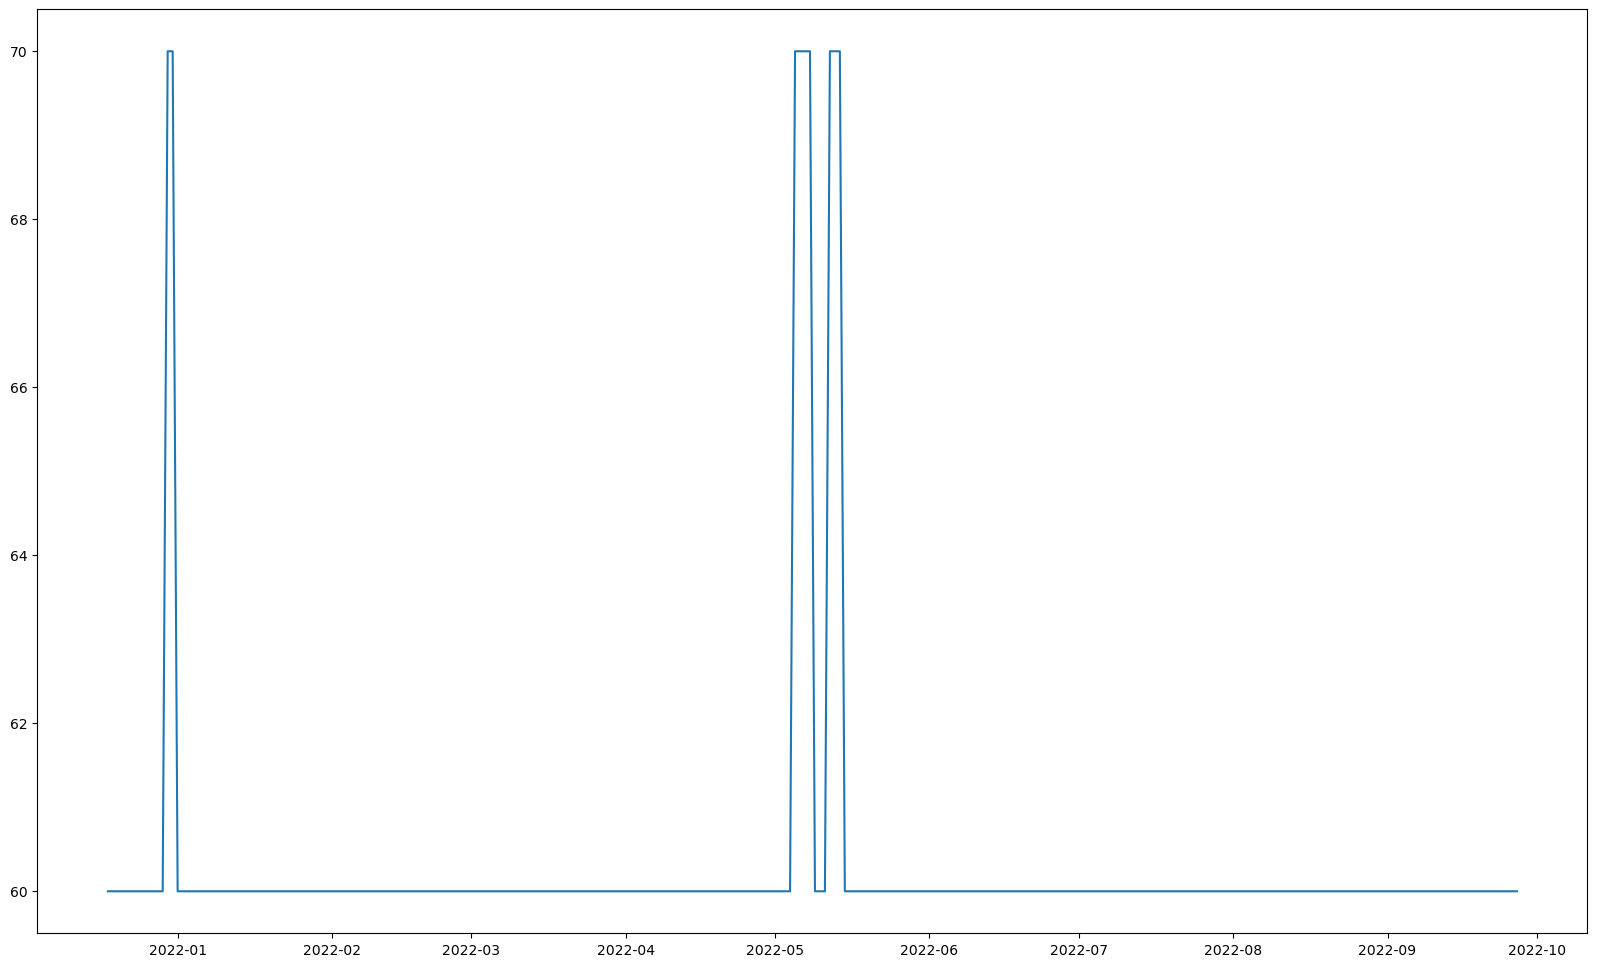

In [260]:
graphing_one_bnb = nashville_data[366:650]
y_graphing_one_bnb = graphing_one_bnb['daily_price']
x_graphing_one_bnb = graphing_one_bnb['date']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(x_graphing_one_bnb, y_graphing_one_bnb)
plt.show()

# fig = plt.figure()
# ax = plt.axes()

# ax.plot(x_graphing_one_bnb, y_graphing_one_bnb);

In [261]:
nashville_modeling_data = nashville_data.drop(['listing_url', 'name', 'picture_url', 'host_id',
                                              'host_url', 'host_identity_verified', 'latitude', 'longitude',
                                              'minimum_nights', 'maximum_nights', 'number_of_reviews',
                                              'instant_bookable', 'review_scores_rating'], axis = 1)
nashville_modeling_data.head()

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,...,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_country_music_hof,distance_to_downtown,distance_to_grand_ole_opry
0,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-17,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
1,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-18,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
2,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-19,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
3,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-20,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
4,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-21,"(36.17315, -86.73581)",2.383663,2.672008,3.395228


In [263]:
nashville_modeling_data['day_of_week'] = nashville_modeling_data['date'].dt.dayofweek
nashville_modeling_data['month'] = nashville_modeling_data['date'].dt.month
nashville_modeling_data['week'] = nashville_modeling_data['date'].dt.week
nashville_modeling_data = nashville_modeling_data.drop(['date'], axis = 1)
nashville_modeling_data.info()

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_5153/4120415660.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  nashville_modeling_data['week'] = nashville_modeling_data['date'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729496 entries, 0 to 1729495
Data columns (total 23 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   listing_id                     int64  
 1   host_is_superhost              float64
 2   room_type                      object 
 3   accommodates                   int64  
 4   bedrooms                       float64
 5   beds                           float64
 6   neighborhood                   object 
 7   bathrooms                      float64
 8   Air conditioning               int64  
 9   Wifi                           int64  
 10  TV                             int64  
 11  Kitchen                        int64  
 12  Washer                         int64  
 13  Dryer                          int64  
 14  Heating                        int64  
 15  daily_price                    int64  
 16  coords                         object 
 17  distance_to_country_music_hof  float64
 18  di

In [264]:
nashville_modeling_data['room_type'].value_counts()

Entire home/apt    1536436
Private room        193060
Name: room_type, dtype: int64

In [265]:
nashville_modeling_data['Heating'].value_counts()

1    1544089
0     185407
Name: Heating, dtype: int64

In [266]:
nashville_modeling_data.describe()

,listing_id,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,distance_to_country_music_hof,distance_to_downtown,distance_to_grand_ole_opry,day_of_week,month,week
count,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06,1.729496e+06
mean,3.346578e+07,5.848796e-01,6.130457e+00,2.139168e+00,3.405894e+00,1.846254e+00,9.220657e-01,9.732055e-01,9.567943e-01,8.896852e-01,7.473096e-01,7.246522e-01,8.927971e-01,2.601051e+02,3.133272e+00,3.178937e+00,6.122835e+00,2.971462e+00,6.496652e+00,2.644631e+01
std,1.505089e+07,4.927429e-01,3.234792e+00,1.090046e+00,2.262765e+00,9.953488e-01,2.680682e-01,1.614824e-01,2.033198e-01,3.132818e-01,4.345550e-01,4.466895e-01,3.093711e-01,1.965799e+02,2.541769e+00,2.594336e+00,2.613397e+00,2.003072e+00,3.457263e+00,1.508313e+01
min,6.422000e+03,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,3.569708e-02,6.859835e-02,2.391563e-01,0.000000e+00,1.000000e+00,1.000000e+00
25%,2.054043e+07,0.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.200000e+02,1.516827e+00,1.414028e+00,4.212078e+00,1.000000e+00,3.000000e+00,1.300000e+01
50%,3.654748e+07,1.000000e+00,6.000000e+00,2.000000e+00,3.000000e+00,1.500000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.990000e+02,2.417191e+00,2.368442e+00,6.111135e+00,3.000000e+00,7.000000e+00,2.600000e+01
75%,4.746609e+07,1.000000e+00,8.000000e+00,3.000000e+00,5.000000e+00,2.500000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.450000e+02,4.019596e+00,3.987928e+00,7.476101e+00,5.000000e+00,1.000000e+01,4.000000e+01
max,5.376534e+07,1.000000e+00,1.600000e+01,6.000000e+00,1.100000e+01,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+03,1.728256e+01,1.722153e+01,2.298622e+01,6.000000e+00,1.200000e+01,5.200000e+01


In [267]:
nashville_modeling_data

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,...,Dryer,Heating,daily_price,coords,distance_to_country_music_hof,distance_to_downtown,distance_to_grand_ole_opry,day_of_week,month,week
0,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,40,"(36.17315, -86.73581)",2.383663,2.672008,3.395228,4,12,50
1,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,40,"(36.17315, -86.73581)",2.383663,2.672008,3.395228,5,12,50
2,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,40,"(36.17315, -86.73581)",2.383663,2.672008,3.395228,6,12,50
3,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,40,"(36.17315, -86.73581)",2.383663,2.672008,3.395228,0,12,51
4,6422,1.0,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,40,"(36.17315, -86.73581)",2.383663,2.672008,3.395228,1,12,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729491,53765339,0.0,Entire home/apt,8,3.0,4.0,Nashville,2.0,1,1,...,0,0,88,"(36.17123, -86.81577)",2.456708,1.872995,7.362911,0,12,50
1729492,53765339,0.0,Entire home/apt,8,3.0,4.0,Nashville,2.0,1,1,...,0,0,88,"(36.17123, -86.81577)",2.456708,1.872995,7.362911,1,12,50
1729493,53765339,0.0,Entire home/apt,8,3.0,4.0,Nashville,2.0,1,1,...,0,0,88,"(36.17123, -86.81577)",2.456708,1.872995,7.362911,2,12,50
1729494,53765339,0.0,Entire home/apt,8,3.0,4.0,Nashville,2.0,1,1,...,0,0,101,"(36.17123, -86.81577)",2.456708,1.872995,7.362911,2,12,50


In [268]:
nashville_modeling_data.columns

Index(['listing_id', 'host_is_superhost', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'neighborhood', 'bathrooms', 'Air conditioning',
       'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating', 'daily_price',
       'coords', 'distance_to_country_music_hof', 'distance_to_downtown',
       'distance_to_grand_ole_opry', 'day_of_week', 'month', 'week'],
      dtype='object')

## Baseline Model - Neural Network

In [269]:
#One hot encode the categorical columns
baseline_model_sklearn = nashville_modeling_data
baseline_model_cat = baseline_model_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(baseline_model_cat)

baseline_model_cat_ohe = pd.DataFrame(data = ohe.transform(baseline_model_cat),
                              columns = ohe.get_feature_names_out())
baseline_model_cat_ohe

,room_type_Private room,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1729492,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1729493,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1729494,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [270]:
#Merge the one hot encoded dataframe and the numeric columns
baseline_model_numeric = nashville_modeling_data[['listing_id', 'daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'week']]

baseline_model_comb_ohe = baseline_model_numeric.join(baseline_model_cat_ohe, how = 'left')
# baseline_model_comb_ohe = baseline_model_comb_ohe.groupby(['listing_id', 'week']).mean()
# baseline_model_comb_ohe = baseline_model_comb_ohe.reset_index()
# baseline_model_comb_ohe = baseline_model_comb_ohe.drop(['week'], axis = 1)
baseline_model_comb_ohe


,listing_id,daily_price,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,6422,40,1.0,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6422,40,1.0,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6422,40,1.0,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,6422,40,1.0,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6422,40,1.0,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729491,53765339,88,0.0,8,3.0,4.0,2.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1729492,53765339,88,0.0,8,3.0,4.0,2.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1729493,53765339,88,0.0,8,3.0,4.0,2.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1729494,53765339,101,0.0,8,3.0,4.0,2.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [271]:
baseline_model_X = baseline_model_comb_ohe.drop(['daily_price', 'listing_id'], axis = 1)
baseline_model_y = baseline_model_comb_ohe['daily_price']

baseline_model_X_train, baseline_model_X_test, baseline_model_y_train, baseline_model_y_test = train_test_split(
                                                                                                baseline_model_X, 
                                                                                                baseline_model_y, 
                                                                                                test_size = 0.18)

baseline_model_X_train, baseline_model_X_val, baseline_model_y_train, baseline_model_y_val = train_test_split(
                                                                                                baseline_model_X_train, 
                                                                                                baseline_model_y_train,
                                                                                                test_size = 0.12)

#### Instantiate a new scaler
scaler = StandardScaler()

baseline_model_X_train_scaled = scaler.fit_transform(baseline_model_X_train)
baseline_model_X_test_scaled = scaler.transform(baseline_model_X_test)
baseline_model_X_val_scaled = scaler.transform(baseline_model_X_val)

In [272]:
#Instantiate a Regularizer

reg = l2(3e-3)

baseline_model_nn = models.Sequential()
baseline_model_nn.add(layers.Flatten())
baseline_model_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
baseline_model_nn.add(layers.Dropout(0.5))
baseline_model_nn.add(layers.Dense(1))


#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
baseline_model_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
baseline_model_nn_histoire = baseline_model_nn.fit(baseline_model_X_train_scaled,
                                                   baseline_model_y_train.values,
                                                   callbacks = [es],
                                                   epochs = 50,
                                                   batch_size = 1000,
                                                   validation_data = (baseline_model_X_val_scaled, 
                                                                      baseline_model_y_val.values))

2023-01-02 22:07:32.995005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-02 22:07:32.995781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Epoch 1/50


2023-01-02 22:07:33.450081: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 22:07:33.666216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1249 [==============================] - ETA: 0s - loss: 258.3236 - mse: 105194.1875 - mae: 258.2223

2023-01-02 22:07:41.531481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1249 [==============================] - 9s 7ms/step - loss: 258.3236 - mse: 105194.1875 - mae: 258.2223 - val_loss: 256.1250 - val_mse: 103994.8047 - val_mae: 255.9848
Epoch 2/50
1249/1249 [==============================] - 9s 7ms/step - loss: 253.6837 - mse: 102577.9062 - mae: 253.4776 - val_loss: 250.7809 - val_mse: 100968.8672 - val_mae: 250.4952
Epoch 3/50
1249/1249 [==============================] - 8s 6ms/step - loss: 247.4091 - mse: 99069.7500 - mae: 247.0214 - val_loss: 243.5466 - val_mse: 96935.3906 - val_mae: 243.0445
Epoch 4/50
1249/1249 [==============================] - 9s 7ms/step - loss: 239.1599 - mse: 94597.6641 - mae: 238.5250 - val_loss: 234.4195 - val_mse: 92000.7891 - val_mae: 233.6422
Epoch 5/50
1249/1249 [==============================] - 8s 7ms/step - loss: 229.2402 - mse: 89389.2422 - mae: 228.3046 - val_loss: 223.7225 - val_mse: 86386.1875 - val_mae: 222.6193
Epoch 6/50
1249/1249 [==============================] - 8s 6ms/step - loss: 218.0996 - mse: 83679

Epoch 46/50
1249/1249 [==============================] - 8s 7ms/step - loss: 127.0282 - mse: 32486.6504 - mae: 124.6670 - val_loss: 106.3010 - val_mse: 24862.8770 - val_mae: 103.9689
Epoch 47/50
1249/1249 [==============================] - 8s 7ms/step - loss: 126.7154 - mse: 32371.7715 - mae: 124.4108 - val_loss: 106.1380 - val_mse: 24810.9277 - val_mae: 103.8600
Epoch 48/50
1249/1249 [==============================] - 8s 7ms/step - loss: 126.5320 - mse: 32317.8867 - mae: 124.2806 - val_loss: 105.9818 - val_mse: 24763.6738 - val_mae: 103.7582
Epoch 49/50
1249/1249 [==============================] - 8s 7ms/step - loss: 126.2618 - mse: 32227.9590 - mae: 124.0640 - val_loss: 105.8317 - val_mse: 24723.6660 - val_mae: 103.6604
Epoch 50/50
1249/1249 [==============================] - 8s 7ms/step - loss: 126.0158 - mse: 32144.5371 - mae: 123.8713 - val_loss: 105.7139 - val_mse: 24714.9082 - val_mae: 103.5958


In [273]:
baseline_model_nn_results_train = baseline_model_nn.evaluate(baseline_model_X_train_scaled, 
                                                             baseline_model_y_train.values)
baseline_model_nn_results_test = baseline_model_nn.evaluate(baseline_model_X_test_scaled, 
                                                            baseline_model_y_test.values)

print(f'Baseline Model Neural Network Train Results: {baseline_model_nn_results_train}')
print(f'Baseline Model Neural Network Test Results: {baseline_model_nn_results_test}')

9729/9729 [==============================] - 43s 4ms/step - loss: 106.0264 - mse: 24765.3340 - mae: 103.9084
Baseline Model Neural Network Train Results: [105.79269409179688, 24649.42578125, 103.67462921142578]
Baseline Model Neural Network Test Results: [106.02640533447266, 24765.333984375, 103.90836334228516]


In [274]:
baseline_model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 82)                0         
                                                                 
 dense (Dense)               (None, 16)                1328      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [275]:
baseline_model_nn_train_preds = baseline_model_nn.predict(baseline_model_X_train_scaled)
baseline_model_nn_test_preds = baseline_model_nn.predict(baseline_model_X_test_scaled)

2023-01-02 22:18:03.749696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


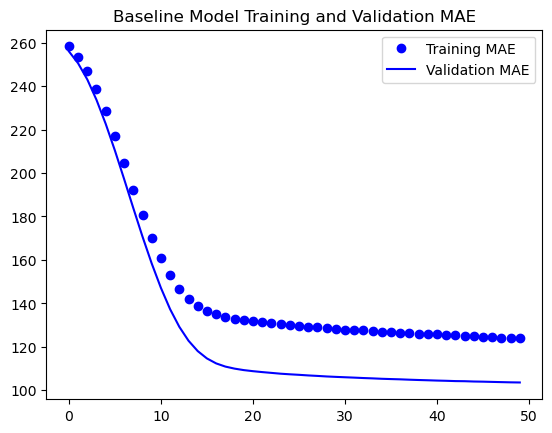

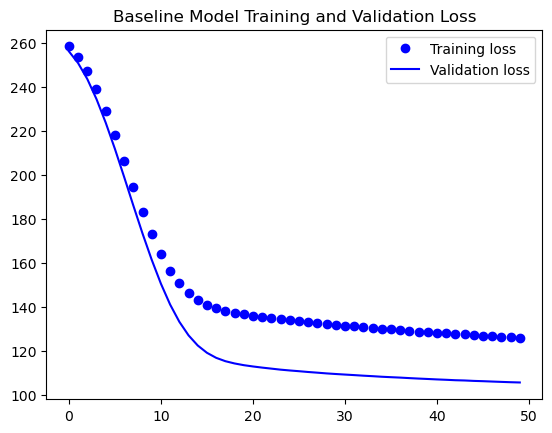

In [276]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
baseline_model_mae = baseline_model_nn_histoire.history['mae']
baseline_model_val_mae = baseline_model_nn_histoire.history['val_mae']
baseline_model_loss = baseline_model_nn_histoire.history['loss']
baseline_model_val_loss = baseline_model_nn_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_mae))

plt.plot(baseline_model_epochs, baseline_model_mae, 'bo', label = 'Training MAE')
plt.plot(baseline_model_epochs, baseline_model_val_mae, 'b', label = 'Validation MAE')
plt.title('Baseline Model Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.show();

In [277]:
print(f'Baseline Model train MAE w/ preds {mean_absolute_error(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model test MAE w/ preds {mean_absolute_error(baseline_model_y_test.values, baseline_model_nn_test_preds)}')

print(f'Baseline Model explained variance train score {explained_variance_score(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model explained variance test score {explained_variance_score(baseline_model_y_test.values, baseline_model_nn_test_preds)}')


print(f'Baseline Model test RMSE {mean_squared_error(baseline_model_y_test.values, baseline_model_nn_test_preds, squared = False)}')



Baseline Model train MAE w/ preds 103.67436869665408
Baseline Model test MAE w/ preds 103.90838064436227
Baseline Model explained variance train score 0.43907355440390694
Baseline Model explained variance test score 0.43911889401678916
Baseline Model test RMSE 157.37017988741988


## Model 2 - Neural Network

In [278]:
#One hot encode the categorical columns
model2_sklearn = nashville_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())

#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = nashville_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'distance_to_country_music_hof', 'distance_to_downtown',
                                          'distance_to_grand_ole_opry']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')

In [279]:
#Begin modeling - set X and y variables
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.18)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

#Instantiate a new scaler
scaler = StandardScaler()

#Scale all columns
model2_X_train_scaled = scaler.fit_transform(model2_X_train)
model2_X_test_scaled = scaler.transform(model2_X_test)
model2_X_val_scaled = scaler.transform(model2_X_val)

In [280]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.025)

In [281]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Begin a new Sequential Model
model2_nn = models.Sequential()
#Consider going bigger to smaller filters between conv1d layers
model2_nn.add(layers.Conv1D(filters = 50, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.Dropout(0.5))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Conv1D(filters = 25, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Dropout(0.4))
model2_nn.add(layers.Flatten())
## model2_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
## model2_nn.add(layers.Dropout(0.3))
# model2_nn.add(layers.Dense(64, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
# model2_nn.add(layers.Dense(32, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
# model2_nn.add(layers.Dropout(0.3))
model2_nn.add(layers.Dense(16, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(8, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.001, patience = 10)
early = [EarlyStopping(monitor='mae', min_delta = 0.001, patience = 20, mode = 'min'),
         ModelCheckpoint(filepath = 'nashville_model2.h5', monitor = 'mae', save_best_only = True),
         LearningRateScheduler(scheduler)]

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train_scaled,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 120,
                                   batch_size = 1000,
                                   validation_data = (model2_X_val_scaled, model2_y_val.values))

Epoch 1/120


2023-01-02 22:21:22.247138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1249 [==============================] - ETA: 0s - loss: 171.2791 - mse: 61784.5273 - mae: 171.0841

2023-01-02 22:21:46.201134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1249 [==============================] - 26s 20ms/step - loss: 171.2791 - mse: 61784.5273 - mae: 171.0841 - val_loss: 112.1404 - val_mse: 30901.3301 - val_mae: 111.8663
Epoch 2/120
1249/1249 [==============================] - 25s 20ms/step - loss: 108.3533 - mse: 26488.0625 - mae: 108.0461 - val_loss: 101.7559 - val_mse: 23961.4980 - val_mae: 101.4236
Epoch 3/120
1249/1249 [==============================] - 25s 20ms/step - loss: 103.3718 - mse: 23676.6660 - mae: 103.0167 - val_loss: 98.1486 - val_mse: 22084.8164 - val_mae: 97.7698
Epoch 4/120
1249/1249 [==============================] - 24s 19ms/step - loss: 100.4553 - mse: 22181.0469 - mae: 100.0559 - val_loss: 95.5108 - val_mse: 20638.4609 - val_mae: 95.0912
Epoch 5/120
1249/1249 [==============================] - 24s 19ms/step - loss: 98.3125 - mse: 21262.0684 - mae: 97.8720 - val_loss: 93.5469 - val_mse: 19805.1523 - val_mae: 93.0867
Epoch 6/120
1249/1249 [==============================] - 24s 19ms/step - loss: 96.8384 - mse: 2

1249/1249 [==============================] - 24s 19ms/step - loss: 90.0413 - mse: 18415.1016 - mae: 89.5856 - val_loss: 86.1387 - val_mse: 17165.1270 - val_mae: 85.6844
Epoch 47/120
1249/1249 [==============================] - 23s 19ms/step - loss: 90.0150 - mse: 18422.3496 - mae: 89.5613 - val_loss: 86.5142 - val_mse: 16932.5918 - val_mae: 86.0612
Epoch 48/120
1249/1249 [==============================] - 24s 19ms/step - loss: 89.9776 - mse: 18383.7988 - mae: 89.5253 - val_loss: 86.0056 - val_mse: 17110.1816 - val_mae: 85.5545
Epoch 49/120
1249/1249 [==============================] - 24s 19ms/step - loss: 89.9016 - mse: 18382.2871 - mae: 89.4506 - val_loss: 85.8882 - val_mse: 16956.3711 - val_mae: 85.4379
Epoch 50/120
1249/1249 [==============================] - 24s 19ms/step - loss: 89.8912 - mse: 18370.8164 - mae: 89.4417 - val_loss: 85.9669 - val_mse: 16978.0879 - val_mae: 85.5181
Epoch 51/120
1249/1249 [==============================] - 24s 19ms/step - loss: 89.7916 - mse: 18328.75

1249/1249 [==============================] - 22s 18ms/step - loss: 88.2202 - mse: 17895.8184 - mae: 87.7879 - val_loss: 83.8002 - val_mse: 16501.4922 - val_mae: 83.3680
Epoch 92/120
1249/1249 [==============================] - 22s 18ms/step - loss: 88.1317 - mse: 17854.1621 - mae: 87.6993 - val_loss: 83.8592 - val_mse: 16413.0957 - val_mae: 83.4269
Epoch 93/120
1249/1249 [==============================] - 22s 18ms/step - loss: 88.2062 - mse: 17868.5215 - mae: 87.7741 - val_loss: 83.8291 - val_mse: 16510.8086 - val_mae: 83.3972
Epoch 94/120
1249/1249 [==============================] - 22s 18ms/step - loss: 88.1588 - mse: 17876.2539 - mae: 87.7268 - val_loss: 83.7569 - val_mse: 16528.4473 - val_mae: 83.3247
Epoch 95/120
1249/1249 [==============================] - 22s 18ms/step - loss: 88.0632 - mse: 17837.5605 - mae: 87.6308 - val_loss: 83.7346 - val_mse: 16596.0156 - val_mae: 83.3022
Epoch 96/120
1249/1249 [==============================] - 23s 18ms/step - loss: 88.0337 - mse: 17798.22

In [282]:
model2_nn_results_train = model2_nn.evaluate(model2_X_train_scaled, model2_y_train.values)
model2_nn_results_test = model2_nn.evaluate(model2_X_test_scaled, model2_y_test.values)

print(f'Model 2 Neural Network Train Results: {model2_nn_results_train}')
print(f'Model 2 Neural Network Test Results: {model2_nn_results_test}')

9729/9729 [==============================] - 58s 6ms/step - loss: 82.6409 - mse: 16161.4795 - mae: 82.2114
Model 2 Neural Network Train Results: [82.62508392333984, 16097.4267578125, 82.19551849365234]
Model 2 Neural Network Test Results: [82.64086151123047, 16161.4794921875, 82.21138000488281]


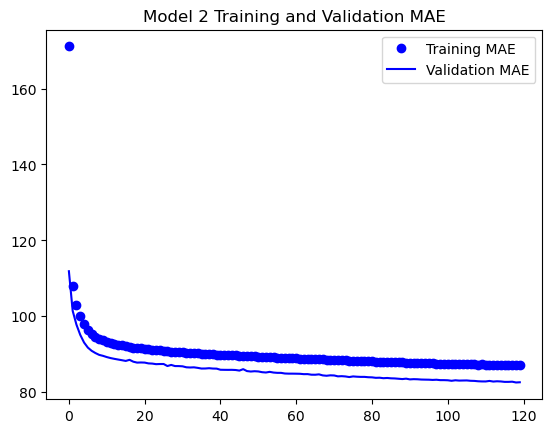

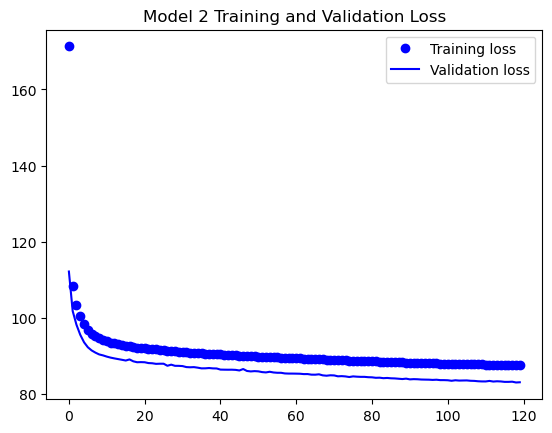

In [283]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
model2_mae = model2_nn_histoire.history['mae']
model2_val_mae = model2_nn_histoire.history['val_mae']
model2_loss = model2_nn_histoire.history['loss']
model2_val_loss = model2_nn_histoire.history['val_loss']
model2_epochs = range(len(model2_mae))

plt.plot(model2_epochs, model2_mae, 'bo', label = 'Training MAE')
plt.plot(model2_epochs, model2_val_mae, 'b', label = 'Validation MAE')
plt.title('Model 2 Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(model2_epochs, model2_loss, 'bo', label = 'Training loss')
plt.plot(model2_epochs, model2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.legend()
plt.show();

In [284]:
model2_nn_train_preds = model2_nn.predict(model2_X_train_scaled)
model2_nn_test_preds = model2_nn.predict(model2_X_test_scaled)

2023-01-02 23:13:34.972861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [285]:
print(f'Model 2 train MAE w/ preds {mean_absolute_error(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 test MAE w/ preds {mean_absolute_error(model2_y_test.values, model2_nn_test_preds)}')

print(f'Model 2 explained variance train score {explained_variance_score(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 explained variance test score {explained_variance_score(model2_y_test.values, model2_nn_test_preds)}')

print(f'Model 2 test RMSE {mean_squared_error(model2_y_test.values, model2_nn_test_preds, squared = False)}')

Model 2 train MAE w/ preds 82.19555046667917
Model 2 test MAE w/ preds 82.21124943577624
Model 2 explained variance train score 0.5926652651944249
Model 2 explained variance test score 0.5923318247425033
Model 2 test RMSE 127.12780304740897


In [286]:
# best_model2_nn_model = load_model('asheville_model2.h5')
# best_model2_nn_y_test_pred = best_model2_nn_model.predict(model2_X_test_scaled)
# print(mean_squared_error(best_y_test_pred, y_test))
# print(mean_squared_error(best_y_test_pred, y_test, squared = False))
# print(mean_absolute_error(best_y_test_pred, y_test))

## Model 3 - Random Forest

In [287]:
import time 

In [291]:
%%time

model3_X = nashville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model3_y = nashville_modeling_data['daily_price']

model3_X_train, model3_X_test, model3_y_train, model3_y_test = train_test_split(model3_X, 
                                                                                model3_y, 
                                                                                test_size = 0.2)

model3_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_country_music_hof', 'distance_to_downtown', 'distance_to_grand_ole_opry']

model3_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model3_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model3_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model3_nominal_pipeline, model3_nominal_cols ),
                        ('numpipe', model3_numeric_pipeline, model3_numeric_cols)])

model3_final_pipe = Pipeline([('preprocess', ct),
                              ('model', RandomForestRegressor())])

model3_results = model3_final_pipe.fit(model3_X_train, model3_y_train)

CPU times: user 15min 9s, sys: 4.8 s, total: 15min 14s
Wall time: 15min 14s


Model 3 train accuracy 0.9939465335790323
Model 3 train MSE 15.289420881689958
Model 3 train MAE 4.615672019127005


Model 3 test accuracy 0.9596067529769188
Model 3 test MSE 39.563316691148245
Model 3 test MAE 12.135341135662603


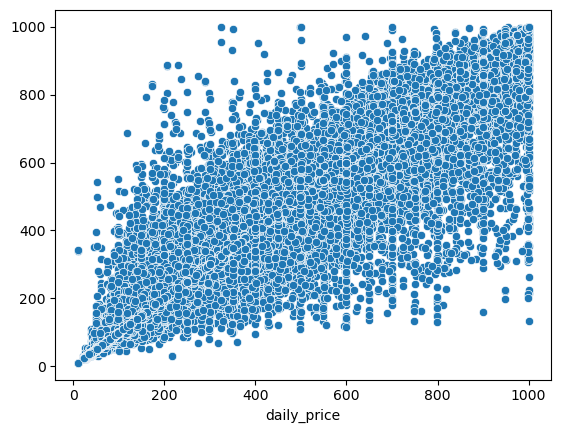

In [292]:
model3_train_preds = model3_final_pipe.predict(model3_X_train)
model3_test_preds = model3_final_pipe.predict(model3_X_test)

print(f'Model 3 train accuracy {model3_final_pipe.score(model3_X_train, model3_y_train)}')
print(f'Model 3 train MSE {mean_squared_error(model3_y_train, model3_train_preds, squared = False)}')
print(f'Model 3 train MAE {mean_absolute_error(model3_y_train, model3_train_preds)}')
print(f'\n')
print(f'Model 3 test accuracy {model3_final_pipe.score(model3_X_test, model3_y_test)}')
print(f'Model 3 test MSE {mean_squared_error(model3_y_test, model3_test_preds, squared = False)}')
print(f'Model 3 test MAE {mean_absolute_error(model3_y_test, model3_test_preds)}')

sns.scatterplot(y = model3_test_preds, x = model3_y_test);

In [293]:
# model3_coeffs = dict(zip(model3_final_pipe['preprocess'].get_feature_names_out(), 
#                                  model3_final_pipe['model'].feature_importances_))
# model3_coeffs = sorted(model3_coeffs.items(), key = lambda x:x[1])
# model3_coeffs

## Model 4 - Random Forest GridSearch

In [296]:
model4_X = nashville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model4_y = nashville_modeling_data['daily_price']

model4_X_train, model4_X_test, model4_y_train, model4_y_test = train_test_split(model4_X, 
                                                                                model4_y, 
                                                                                test_size = 0.2)

model4_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_country_music_hof', 'distance_to_downtown', 'distance_to_grand_ole_opry']

model4_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model4_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model4_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model4_nominal_pipeline, model4_nominal_cols ),
                        ('numpipe', model4_numeric_pipeline, model4_numeric_cols)])

model4_final_pipe = Pipeline([('preprocess', ct),
                              ('rf', RandomForestRegressor(min_samples_leaf = 23,
                                                          max_depth = 23,
                                                           min_samples_split = 23))])

# model4_param_range = [1, 2, 3, 4, 5, 6]
                     
# model4_rf_param_grid = [{'rf__min_samples_leaf': model4_param_range,
#                          'rf__max_depth': model4_param_range,
#                          'rf__min_samples_split': model4_param_range[1:]}]
                     
# model4_rf_grid_search = GridSearchCV(estimator = model4_final_pipe,
#                                      param_grid = model4_rf_param_grid,
#                                      scoring = 'explained_variance',
#                                      cv = 3,
#                                      n_jobs = -10)
                     
# model4_rf_grid_search.fit(model4_X_train, model4_y_train)
model4_final_pipe.fit(model4_X_train, model4_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['neighborhood', 'room_type',
                                                   'day_of_week', 'month',
                                                   'week']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['host_is_superhost',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'Air conditioning', 'Wifi',
                                                   'TV', 'Kitchen', 'Washer',
                                                   'Dryer', 'Heating',
                                                   'distance_to_country_music_hof',
                                                   'distance_to_downtown',
                                                   'distance_to_grand_ole_opry'])])),
                ('rf',
                 RandomForestRegressor(max_depth=23, min_samples_leaf=23,
                                       min_samples_split=23))])

Model 4 train accuracy 0.9037314630555628
Model 4 train MSE 60.970149161706864
Model 4 train MAE 28.28335903462294


Model 4 test accuracy 0.8962409182673262
Model 4 test MSE 63.41656131072626
Model 4 test MAE 29.458162631331682


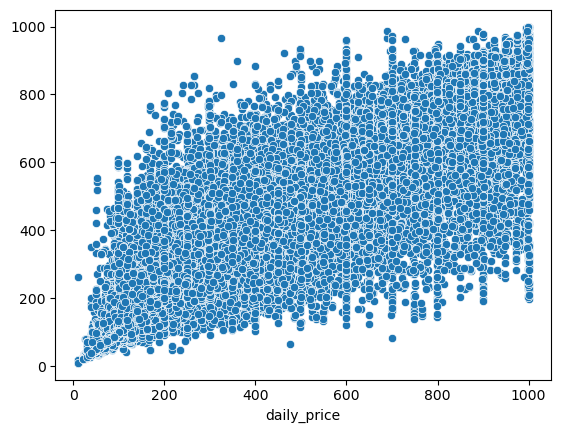

In [297]:
model4_train_preds = model4_final_pipe.predict(model4_X_train)
model4_test_preds = model4_final_pipe.predict(model4_X_test)

print(f'Model 4 train accuracy {model4_final_pipe.score(model4_X_train, model4_y_train)}')
print(f'Model 4 train MSE {mean_squared_error(model4_y_train, model4_train_preds, squared = False)}')
print(f'Model 4 train MAE {mean_absolute_error(model4_y_train, model4_train_preds)}')
print(f'\n')
print(f'Model 4 test accuracy {model4_final_pipe.score(model4_X_test, model4_y_test)}')
print(f'Model 4 test MSE {mean_squared_error(model4_y_test, model4_test_preds, squared = False)}')
print(f'Model 4 test MAE {mean_absolute_error(model4_y_test, model4_test_preds)}')

sns.scatterplot(y = model4_test_preds, x = model4_y_test);

## Testing Predictions

In [ ]:
host_superhost = input('Host is Superhost (Y/N): ')
room_type = input('Room Type (Entire home/apt or Private room)')
accommodates = input('Accomodates (1-16) Guests: ')
num_of_bedrooms = input('Number of Bedrooms: ')
num_of_beds = input('Number of Beds: ')
select_neighborhood = input('Neighborhood (Asheville/Candler/Fletcher/Woodfin): ')
num_of_bathrooms = input('Number of Bathrooms: ')
check_AC = input('AC (Y/N): ')
check_wifi = input('Wifi (Y/N): ')
check_TV = input('TV (Y/N): ')
check_kitchen = input('Kitchen (Y/N): ')
check_washer = input('Washer (Y/N): ')
check_dryer = input('Dryer (Y/N): ')
check_heating = input('Heating (Y/N): ')
select_latitude = input('Latitude: ')
select_longitude = input('Longitude: ')
checkin_date = input('Check-in Date: ')
checkout_date = input('Check-out Date: ')


Host is Superhost (Y/N): Y
Room Type (Entire home/apt or Private room)Entire home/apt
Accomodates (1-16) Guests: 5
Number of Bedrooms: 6
Number of Beds: 8


In [115]:
def yes_no_conversion(input):
    if input == 'Y':
        return 1
    else:
        return 0

In [117]:
conv_long = float(select_longitude)
conv_lat = float(select_latitude)
test_coords = list((conv_lat, conv_long))
predicted_checkin_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
                          test_coords,
                          geodesic(test_coords, biltmore).miles,
                          geodesic(test_coords, downtown).miles,
                          pd.to_datetime(checkin_date).dayofweek,
                          pd.to_datetime(checkin_date).month,
                          pd.to_datetime(checkin_date).week]
#may need to reshape with 1, -1 for actual prediction or .to_frame()

In [118]:
checkin_prediction_df = pd.DataFrame(predicted_checkin_list).T
checkin_prediction_df = checkin_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
                                      14: 'coords',
                                      15: 'distance_to_biltmore',
                                      16: 'distance_to_downtown',
                                      17: 'day_of_week',
                                      18: 'month',
                                      19: 'week'}, axis = 1)

checkin_prediction_df

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,coords,distance_to_biltmore,distance_to_downtown,day_of_week,month,week
0,1,Entire home/apt,2,2,2,Asheville,2,1,1,1,1,1,1,1,"[20.0, -20.0]",3912.65183,3912.128241,6,1,52


In [122]:
predicted_checkout_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
                          test_coords,
                          geodesic(test_coords, biltmore).miles,
                          geodesic(test_coords, downtown).miles,
                          pd.to_datetime(checkout_date).dayofweek,
                          pd.to_datetime(checkout_date).month,
                          pd.to_datetime(checkout_date).week]
#may need to reshape with 1, -1 for actual prediction or .to_frame()

In [123]:
checkout_prediction_df = pd.DataFrame(predicted_checkout_list).T
checkout_prediction_df = checkout_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
                                      14: 'coords',
                                      15: 'distance_to_biltmore',
                                      16: 'distance_to_downtown',
                                      17: 'day_of_week',
                                      18: 'month',
                                      19: 'week'}, axis = 1)

checkout_prediction_df

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,coords,distance_to_biltmore,distance_to_downtown,day_of_week,month,week
0,1,Entire home/apt,2,2,2,Asheville,2,1,1,1,1,1,1,1,"[20.0, -20.0]",3912.65183,3912.128241,4,12,48


In [124]:
print(f'${float(model3_final_pipe.predict(checkout_prediction_df))} per night')
print(f'${float(model3_final_pipe.predict(checkin_prediction_df))} per night')

$290.59 per night
$270.0 per night


In [125]:
#XGBoost, rf gridsearch
    #save the models and use for other data/preprocess

In [ ]:
#Creating a .py file - here will need all the parameters the function will use